In [424]:
import os
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

In [526]:
# Number of Qubits 
N=6
# Number of excitations
k=3
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=400
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

 Qubit indices in chain: 
 [0 1 2 3 4 5]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5)]

 Initialization strategy is: 
 [0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5]


In [527]:
# Deciding between grid and 1d chain topology
my_topology = my_chain

In [528]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

Min. cost portfolio (constrained subspace): 4.792675492871994
Optimal portfolio state (constrained subspace) is: |010110>


In [529]:

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")


Min. cost QUBO: 4.792675492871986
Min. cost QUBO state is: |010110>


In [530]:
print("Check that qubo min cost is same as portfolio min cost:")
qubo_min_cost, portfolio_subspace_min_cost

Check that qubo min cost is same as portfolio min cost:


(4.792675492871986, 4.792675492871994)

In [531]:
print("Check that qubo max cost is at least portfolio max cost:")
qubo_max_cost, portfolio_subspace_max_cost

Check that qubo max cost is at least portfolio max cost:


(75.16958453646555, 11.185011781432737)

In [532]:
# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=True)

In [537]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead']
optimizer_method = available_methods[1]

# Designing own convergence tol
convergence_eps = 0.0005

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
CP_z_phase_most_probables = []
solver_costs=[]

def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    CP_z_phase_most_probables.append(list(_dict_.keys())[np.argmax(list(_dict_.values()))])
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    
    new_solver_cost = CP_z_phase_ansatz.get_cost(x)
    if len(solver_costs) > 300:
        solver_costs.append(new_solver_cost)
        if np.std(solver_costs[-300:]) < convergence_eps:
            raise Exception("Termination criteria met")
    else:
        solver_costs.append(new_solver_cost)

# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(0)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * len(my_topology.get_NNN_indices())
N_angles += layers * N # Because this is WITH Z-phase
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")
# Saving initial cost
solver_costs.append(CP_z_phase_ansatz.get_cost(CP_z_phase_theta_i))
try:
    # Performing optimization
    CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, x0=CP_z_phase_theta_i,
                                          method=optimizer_method,
                                          options={'disp': False, 
                                                   'maxiter': max_iter,
                                                   'initial_simplex': np.vstack((np.zeros((1,N_angles)),np.diag([4*np.pi*(-1)**i for i in range(N_angles)]))),
                                                   'adaptive':False},
                                          callback=CP_z_phase_callback_function)
except Exception as e:
    if str(e) == "Termination criteria met":
        print("Optimization stopped due to custom termination criteria.")

CP+Z-PHASE: 19


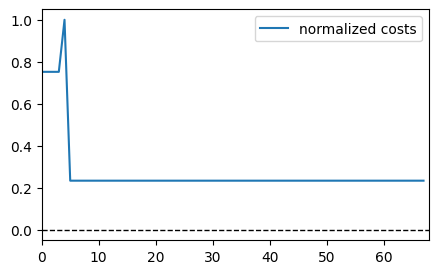

In [538]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='normalized costs')
ax.set_xlim(0,len(CP_z_phase_costs))
ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

In [504]:
np.diag([2*np.pi*(-1)**(2*i+1) for i in range(3)])

array([[-6.28318531,  0.        ,  0.        ],
       [ 0.        , -6.28318531,  0.        ],
       [ 0.        ,  0.        , -6.28318531]])

In [458]:
opt_state = CP_z_phase_most_probables[np.argmin(solver_costs)]
opt_state, ''.join(str(q) for q in portfolio_subspace_min_state_str)

('1010101001', '1010101001')

In [459]:
found_cost = qubo_cost(np.array([float(_) for _ in opt_state]).astype(np.float64), Q) + offset
abs(found_cost - portfolio_subspace_min_cost) / abs(portfolio_subspace_max_cost - portfolio_subspace_min_cost)

4.313062108042641e-15

In [437]:
max_iter = 10000

sizes = [2,3,
         4,5,
         6,7,
         8,9,
         10]

cardinalities = [1,1,
                 2,2,
                 3,3,
                 4,4,
                 5]

layers = [1,1,1,
          2,2,2,
          3,3,3]

initialization_strategies = [np.array([0,1]),
                             np.array([0,1,0]),
                             np.array([0,1,0,1]),
                             np.array([0,1,0,1,0]),
                             np.array([0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1,0,1])]

